<ipython-input-2-76b83123916c>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  country_data['Date'] = pd.to_datetime(country_data['Date'])


🔹 Model Evaluation Summary
GLM - RMSE: 4756887.58, R² Score: 0.9269
Nonlinear - RMSE: 1979805.07, R² Score: 0.9873


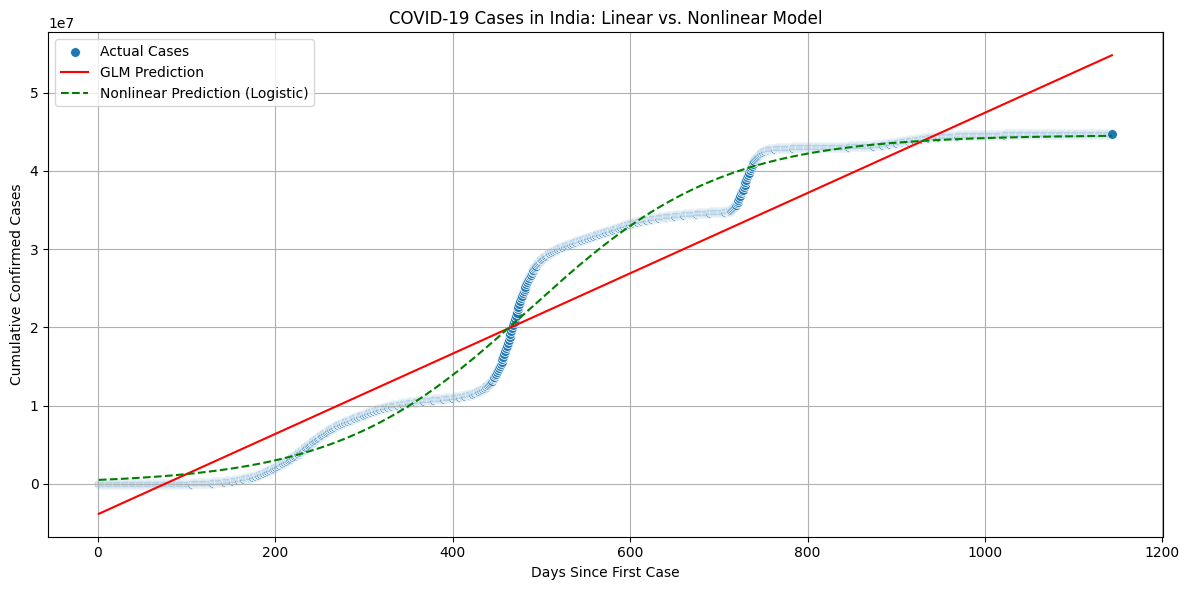

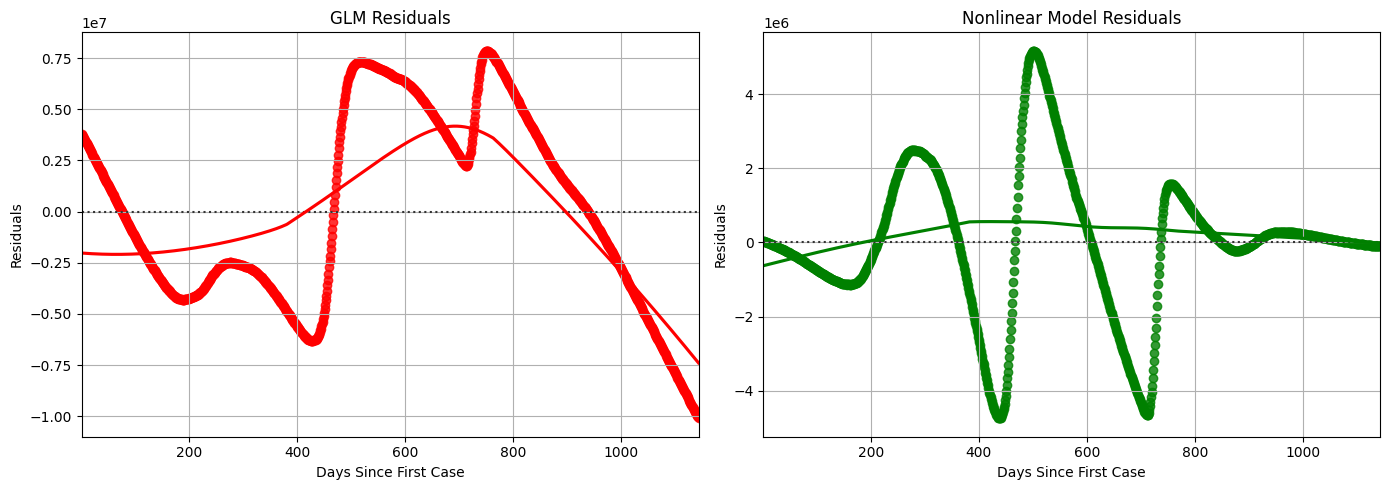

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# 1. Data Acquisition and Preparation
# ----------------------------

# Load the dataset
file_path = '/content/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(file_path)

# Filter for India
country = 'India'
country_data = data[data['Country/Region'] == country].iloc[:, 4:].sum().reset_index()
country_data.columns = ['Date', 'Cases']

# Convert date and calculate days since start
country_data['Date'] = pd.to_datetime(country_data['Date'])
country_data['Days'] = (country_data['Date'] - country_data['Date'].min()).dt.days + 1

# ----------------------------
# 2. Generalized Linear Model (GLM)
# ----------------------------

X_glm = sm.add_constant(country_data['Days'])  # Intercept
glm_model = sm.GLM(country_data['Cases'], X_glm, family=sm.families.Gaussian()).fit()
country_data['GLM_Pred'] = glm_model.predict(X_glm)

# ----------------------------
# 3. Nonlinear Regression - Logistic Growth Model
# ----------------------------

def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Initial guess: L (max), x0 (mid), k (growth rate)
p0 = [max(country_data['Cases']), np.median(country_data['Days']), 0.1]
params, _ = curve_fit(logistic, country_data['Days'], country_data['Cases'], p0=p0)
country_data['Nonlinear_Pred'] = logistic(country_data['Days'], *params)

# ----------------------------
# 4. Evaluation Metrics
# ----------------------------

glm_rmse = np.sqrt(mean_squared_error(country_data['Cases'], country_data['GLM_Pred']))
glm_r2 = r2_score(country_data['Cases'], country_data['GLM_Pred'])

nonlinear_rmse = np.sqrt(mean_squared_error(country_data['Cases'], country_data['Nonlinear_Pred']))
nonlinear_r2 = r2_score(country_data['Cases'], country_data['Nonlinear_Pred'])

print("🔹 Model Evaluation Summary")
print(f"GLM - RMSE: {glm_rmse:.2f}, R² Score: {glm_r2:.4f}")
print(f"Nonlinear - RMSE: {nonlinear_rmse:.2f}, R² Score: {nonlinear_r2:.4f}")

# ----------------------------
# 5. Visualization
# ----------------------------

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Days', y='Cases', data=country_data, label='Actual Cases', s=50)
sns.lineplot(x='Days', y='GLM_Pred', data=country_data, label='GLM Prediction', color='red')
sns.lineplot(x='Days', y='Nonlinear_Pred', data=country_data, label='Nonlinear Prediction (Logistic)', color='green', linestyle='--')
plt.title(f'COVID-19 Cases in {country}: Linear vs. Nonlinear Model')
plt.xlabel('Days Since First Case')
plt.ylabel('Cumulative Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 6. Residual Analysis
# ----------------------------

country_data['GLM_Residuals'] = country_data['Cases'] - country_data['GLM_Pred']
country_data['Nonlinear_Residuals'] = country_data['Cases'] - country_data['Nonlinear_Pred']

plt.figure(figsize=(14, 5))

# GLM Residuals
plt.subplot(1, 2, 1)
sns.residplot(x='Days', y='GLM_Residuals', data=country_data, lowess=True, color='red')
plt.title('GLM Residuals')
plt.xlabel('Days Since First Case')
plt.ylabel('Residuals')
plt.grid(True)

# Nonlinear Residuals
plt.subplot(1, 2, 2)
sns.residplot(x='Days', y='Nonlinear_Residuals', data=country_data, lowess=True, color='green')
plt.title('Nonlinear Model Residuals')
plt.xlabel('Days Since First Case')
plt.ylabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()
